# VLSI - SAT Model

#### Definition of the problem
**Input**: A set *R = {r1, . . . , rn}* of *n* rectangles. Each rectangle
*ri ∈ R* has a width *w_i* and a height *h_i* *(w_i, h_i ∈ N)*. A Strip of
width *W ∈ N*.

**Constraints**: Each rectangle cannot overlap with the others
and the edges of the strip and must be parallel to the horizontal
and the vertical axis.

**Question**: What is the minimum height such that the set of
rectangles can be packed in the given strip?

In [ ]:
!pip3 install z3-solver

In [1]:
import os,sys,inspect,getopt
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
from z3 import *

currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
import utils

### Useful functions 

In [63]:
def large_rectangles(w_i, w_j, h_i, h_j, W, H):
    if w_i + w_j <= W and h_i + h_j <= H:
        return ""
    elif w_i + w_j > W and h_i + h_j <= H:
        return "W"
    elif w_i + w_j <= W and h_i + h_j > H:
        return "H"

def same_rectangles(w1,w2,h1,h2):
    if w1 == w2 and h1 == h2:
        return True
    else:
        return False

def largest_rectangle(idx, max_idx):
    if idx == max_idx:
        return True
    else:
        return False

def getCoords(m, x, y, W, H, n):
    x_sol = []
    y_sol = [] 
    
    for i in range(n):
        j = 0
        while j < W:
            if m.evaluate(x[i][j]):
                x_sol.append(j)
                break
            j += 1

        j = 0
        while j < H:
            if m.evaluate(y[i][j]):
                y_sol.append(j)
                break
            j += 1

    return [x_sol, y_sol]

def no_overlap(W, H, widths, heights, i, j, flip, px, py, lr, ud):    
    if flip and (widths[i] > H or heights[i] > W):
        flip = False
        
    dim1,dim2=(widths[i],heights[i]) if not flip else (heights[i],widths[i])
    cts=[]
    
    if lr:
        # lr(r_i,r_j)-> x_j > w_i
        cts.append(Or(
                Not(lr[i][j]),
                Not(px[j][dim1-1]),
            )) 

        for e in range(0,W-dim1):
            cts.append(Or(
                Not(lr[i][j]),
                px[i][e],
                Not(px[j][e+dim1]),
            ))

    if ud:
        # ud(r_i,r_j)-> y_j > h_i
        cts.append(Or(
                Not(ud[i][j]),
                Not(py[j][dim2-1])
            ))

        for f in range(0,H-dim2):
            cts.append(Or(
                Not(ud[i][j]),
                py[i][f],
                Not(py[j][f+dim2])
            ))

    return cts

def getNewDims(model,widths,heights,f, W, H):
    w=[]
    h=[]
    for i in range(len(widths)):
        if model.evaluate(f[i]) and widths[i] <= H and heights[i] <= W:
            w.append(heights[i])
            h.append(widths[i])
        else:
            w.append(widths[i])
            h.append(heights[i])
    return w,h 

### Model - Order Encoding

[1] https://web.telegram.org/cd003ba1-9c37-41f3-9be7-dceeb848b5e2

[2] https://sourceforge.net/p/potassco/mailman/attachment/1323943585.4102.431.camel@white.sevalidation.com/1/

In [40]:
'''
 # SEARCH SPACE REDUCTION 
    1. Large Rectangles (LR): 
        Reducing the possibilities for placing large rectangles.
        For each rectangle ri and r j, if wi + w j > W we can not pack
        these rectangles in the horizontal direction. We therefore
        modify non-overlapping constraints.
        This technique is also applicable for the vertical direction.

    2. Same Rectangles (SR):
        For each rectangle ri and r j, if (wi, hi) = (w j, h j) we can 
        fix the positional relation of these rectangles. 
        
    3. Largest Rectangle (LS): 
        Reducing the domain for the largest rectangle.
        With breaking symmetries, we can reduce the domain of
        largest rectangle.

                    D(x_i) = {a ∈ N | 0 ≤ a ≤ floor((W − w_i)/2)}
                    D(y_i) = {a ∈ N | 0 ≤ a ≤ floor((H − h_i)/2)}
'''

def vlsi_sat(instance):
    
    ''' VARIABLES '''

    n = instance['n']
    W = instance['w']
        
    widths  = [i[0] for i in instance['dim']]
    heights = [i[1] for i in instance['dim']]

    largest_idx = [w*h for w,h in zip(widths,heights)].index(max([w*h for w,h in\
                                                                        zip(widths,heights)]))   
    
    tot_area=sum([w*h for w,h in zip(widths,heights)])

    lb = int(tot_area/W)
    naiveSolution = utils.computeMostStupidSolution(instance)
    ub = naiveSolution[0][1]+1
    
    print("LB ->", lb)
    print("UB ->", ub)
    
    H = lb
    
    s_time = time.time()
    
    ''' SOLVER WITH 5 MINUTES TIMEOUT'''
    s = Solver()
    s.set("timeout", 300000)
    while (lb < ub):
        if (time.time() > s_time + 300):
            return None, None, None, None, 0.0
        
        '''
        ==================================================================
        Let x_i and y_i be integer variables such that the pair (x_i, y_i)
        represents the position of lower left coordinates of the rectangle
        ri in the strip.
        The domains of x_i and y_i are as folbows.
                            D(x_i) = {a ∈ N | 0 ≤ a ≤ W − w_i}
                            D(y_i) = {a ∈ N | 0 ≤ a ≤ H − h_i}
        ==================================================================
        Let r_i, r_j ∈ R(i != j) be two rectangles. We use two
        kinds of propositional variables: lr_i,j and ud_i,j.
        lr_i,j is true if r_i are placed at the left to the r_j.
        ud_i,j is true if r_i are placed at the downward to the r_j.

        ==================================================================
        For each rectangles r_i,r_j (i < j), we have the non-overlapping
        constraints:
                            lr_i,j ∨ lr_j,i ∨ ud_i,j ∨ ud_j,i
                                ¬lr_i,j ∨ (x_i + w_i ≤ x_j)
                                ¬lr_j,i ∨ (x_j + w_j ≤ x_i)
                                ¬ud_i,j ∨ (y_i + h_i ≤ y_j)
                                ¬ud_j,i ∨ (y_j + h_j ≤ y_i)
        The parts between parentheses are encoded into SAT by using order
        encoding.
        '''
        px = [[Bool(f"px{i+1}_{x}") for x in range(W)] for i in range(n)] # x[i][i]: block i has y coordinate <=j
        py = [[Bool(f"py{i+1}_{y}") for y in range(H)] for i in range(n)] # x[i][i]: block i has y coordinate <=j
        lr = [[Bool(f"lr_{i+1}_{j+1}") if j!=i else 0 for j in range(n)] for i in range(n)]
        ud = [[Bool(f"ud_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)]

        # Exactly One constraint
        for i in range(n): 
            '''
            ==================================================================
            Order encoding is a generalization of the encoding method
            originally used by Crawford and Baker for Job-Shop
            Scheduling problems.
            It uses a different Boolean variable P_x,a representing x ≤ a
            for each integer variable x and integer value a.
            
            For each rectangle r_i, and integer e and f such that
            0 ≤ e ≤ W − wi and 0 ≤ f ≤ H − h_i, we have the 2-literal
            axiom clauses due to order encoding,
                                ¬ px_i,e ∨ px_i,e+1
                                ¬ py_i, f ∨ py_i, f +1
            ==================================================================
            '''
            
            # LS 
            if largest_rectangle(i, largest_idx):
                s.add([px[i][e] for e in range(int((W-widths[i])/2),W)]) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 
                s.add([py[i][f] for f in range(int((H-heights[i])/2),H)]) # same for the y coordinate 
            else:
                s.add([px[i][e] for e in range(W-widths[i],W)]) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 
                s.add([py[i][f] for f in range(H-heights[i],H)]) # same for the y coordinate 
            # LS
            
            s.add([Or(Not(px[i][e]),px[i][e+1]) for e in range(W-1)]) #x[i][j] implies x[i][j+1]
            s.add([Or(Not(py[i][f]),py[i][f+1]) for f in range(H-1)]) #y[i][j] implies y[i][j+1]

            for j in range(n):
                '''
                ==================================================================
                For each rectangles i,j (i < j), we have the non-overlapping
                constraints as the 4-literal clauses:
                                lr_i,j ∨ lr_j,i ∨ ud_i,j ∨ ud_j,i 
                                
                For each rectangles i, j (i < j), and integer e and f such that
                0 ≤ e < W − wi and 0 ≤ f < H − h j, we also have the
                non-overlapping constraints as the 3-literal clauses:
                                ¬lr_i,j ∨ px_i,e ∨ ¬px_j,e + w_i
                                ¬lr_j,i ∨ px_j,e ∨ ¬px_i,e + w_j
                                ¬ud_i,j ∨ py_i,f ∨ ¬py_j,f + h_i
                                ¬ud_j,i ∨ py_j,f ∨ ¬py_i,f + h_j
                ==================================================================
                '''
                # LR 
                if large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "":
                    if i<j and not same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                        if not largest_rectangle(j, largest_idx):
                            s.add(Or(lr[i][j],lr[j][i],ud[i][j],ud[j][i]))

                            s.add(
                                *no_overlap(W,H,widths,heights,i,j,False,px,py,lr,ud),
                                *no_overlap(W,H,widths,heights,j,i,False,px,py,lr,ud)
                            )
                        else:
                            s.add(Or(lr[j][i],ud[i][j],ud[j][i]))

                            s.add(
                                *no_overlap(W,H,widths,heights,i,j,False,px,py,False,ud),
                                *no_overlap(W,H,widths,heights,j,i,False,px,py,lr,ud)
                            )
                            
                    elif i<j and same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                        s.add(Or(lr[i][j],ud[i][j],ud[j][i]))

                        s.add(
                            *no_overlap(W,H,widths,heights,i,j,False,px,py,lr,ud),
                            *no_overlap(W,H,widths,heights,j,i,False,px,py,False,ud)
                        )
                            
                        s.add(Or(
                                Not(ud[i][j]),
                                lr[j][i]
                        ))
                        
                elif large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "W":
                    if i<j:
                        s.add(Or(ud[i][j],ud[j][i]))

                        s.add(
                            *no_overlap(W,H,widths,heights,i,j,False,px,py,False,ud),
                            *no_overlap(W,H,widths,heights,j,i,False,px,py,False,ud)
                        )
                        
                elif large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "H":
                    if i<j and not same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                        s.add(Or(lr[i][j],lr[j][i]))
                        
                        s.add(
                            *no_overlap(W,H,widths,heights,i,j,False,px,py,lr,False),
                            *no_overlap(W,H,widths,heights,j,i,False,px,py,lr,False)
                        )
                        
                    elif i<j and same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                        s.add(lr[i][j])
                        
                        s.add(
                            *no_overlap(W,H,widths,heights,i,j,False,px,py,lr,False)
                        )
                        
                        s.add(Or(
                                Not(ud[i][j]),
                                lr[j][i]
                        ))                    

        if s.check() == sat:
            ub = H
        else:
            lb = H + 1

        H =  int((lb+ub)/2)
        
        '''
        ==================================================================
        'Bisection Method':
            while lb < ub
                o := (lb + ub)/2;
                resubt := Ψ ∪ {ph_o};
                if resubt is SAT
                    then ub := o;
                    else lb := o + 1;
            end while
        ==================================================================
        '''
    
    e_time = time.time() - s_time
    
    return s, px, py, H, e_time

### Execution

Instance: n=4 w=8 dim=[[3, 3], [3, 5], [5, 3], [5, 5]]
LB -> 8
UB -> 9


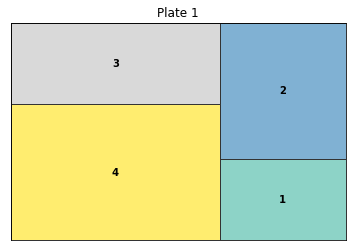

Instance[1] solved in 0.037 s, height: 8


Instance: n=5 w=9 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]
LB -> 9
UB -> 10


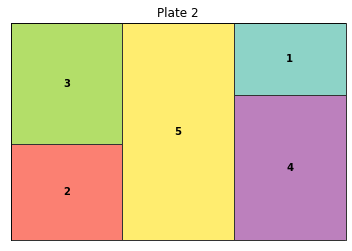

Instance[2] solved in 0.055 s, height: 9


Instance: n=6 w=10 dim=[[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]
LB -> 10
UB -> 11


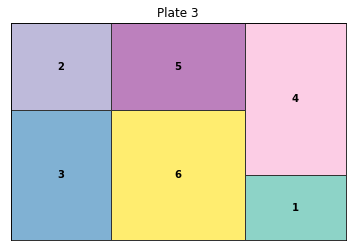

Instance[3] solved in 0.084 s, height: 10


Instance: n=7 w=11 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]
LB -> 11
UB -> 13


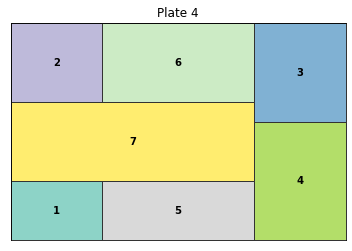

Instance[4] solved in 0.131 s, height: 11


Instance: n=8 w=12 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]
LB -> 12
UB -> 15


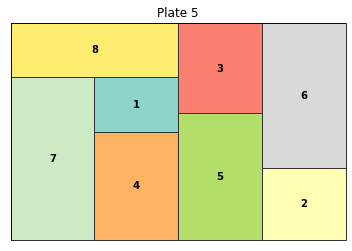

Instance[5] solved in 0.219 s, height: 12


Instance: n=9 w=13 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]
LB -> 13
UB -> 16


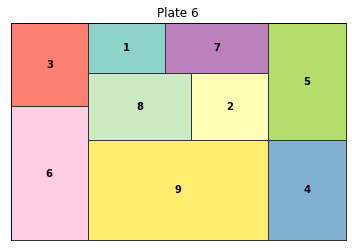

Instance[6] solved in 0.257 s, height: 13


Instance: n=9 w=14 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]
LB -> 14
UB -> 17


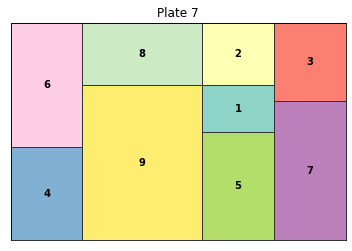

Instance[7] solved in 0.275 s, height: 14


Instance: n=10 w=15 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]
LB -> 15
UB -> 17


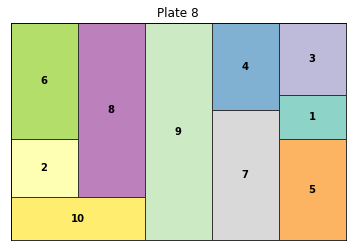

Instance[8] solved in 0.347 s, height: 15


Instance: n=10 w=16 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]
LB -> 16
UB -> 19


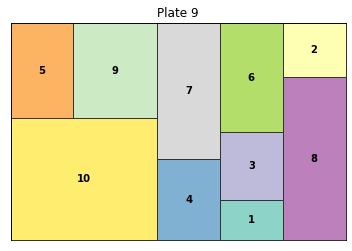

Instance[9] solved in 0.372 s, height: 16


Instance: n=12 w=17 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]
LB -> 17
UB -> 18


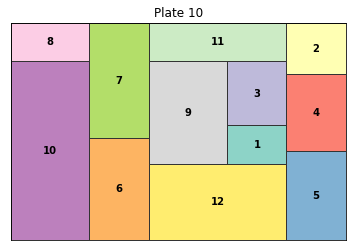

Instance[10] solved in 0.675 s, height: 17


Instance: n=16 w=18 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]
LB -> 18
UB -> 23


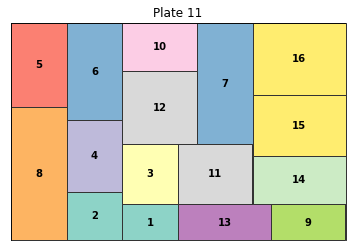

Instance[11] solved in 3.125 s, height: 18


Instance: n=14 w=19 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]
LB -> 19
UB -> 23


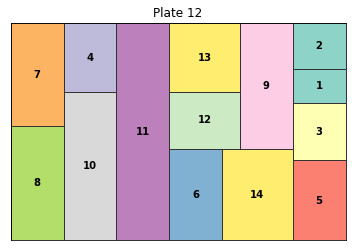

Instance[12] solved in 1.01 s, height: 19


Instance: n=14 w=20 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]
LB -> 20
UB -> 24


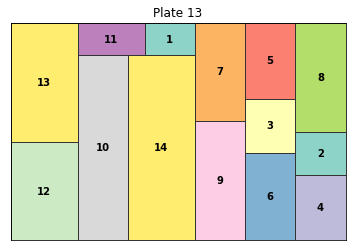

Instance[13] solved in 1.002 s, height: 20


Instance: n=15 w=21 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]
LB -> 21
UB -> 25


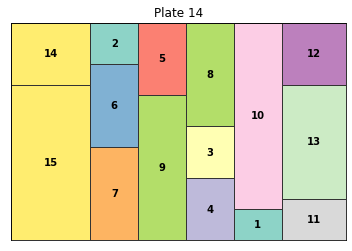

Instance[14] solved in 1.282 s, height: 21


Instance: n=16 w=22 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]
LB -> 22
UB -> 24


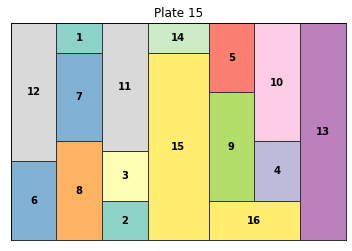

Instance[15] solved in 1.41 s, height: 22


Instance: n=19 w=23 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]
LB -> 23
UB -> 27


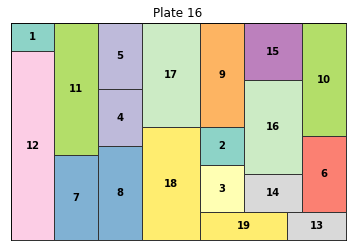

Instance[16] solved in 2.471 s, height: 23


Instance: n=18 w=24 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]
LB -> 24
UB -> 28


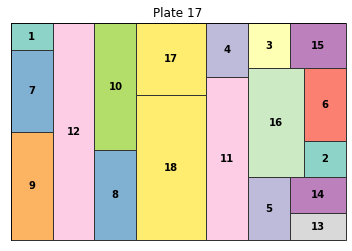

Instance[17] solved in 2.048 s, height: 24


Instance: n=19 w=25 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]
LB -> 25
UB -> 29


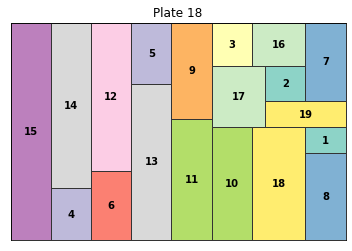

Instance[18] solved in 5.46 s, height: 25


Instance: n=22 w=26 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]
LB -> 26
UB -> 30


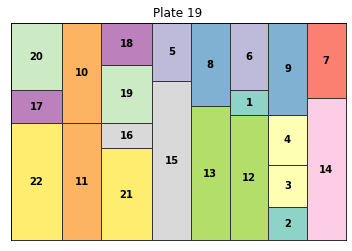

Instance[19] solved in 17.723 s, height: 26


Instance: n=21 w=27 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]
LB -> 27
UB -> 30


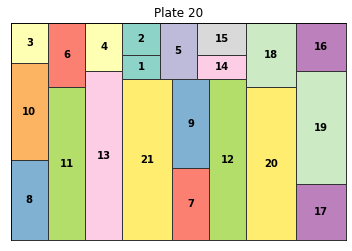

Instance[20] solved in 3.154 s, height: 27


Instance: n=22 w=28 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]
LB -> 28
UB -> 33


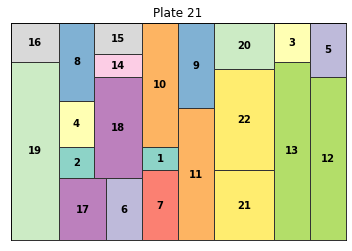

Instance[21] solved in 15.707 s, height: 28


Instance: n=24 w=29 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]
LB -> 29
UB -> 31


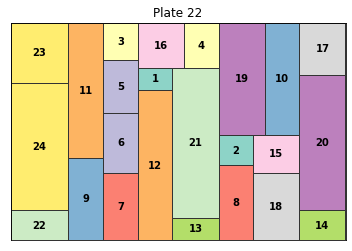

Instance[22] solved in 13.546 s, height: 29


Instance: n=20 w=30 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]
LB -> 30
UB -> 35


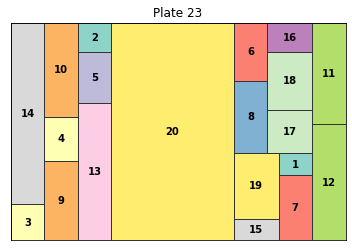

Instance[23] solved in 8.033 s, height: 30


Instance: n=19 w=31 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]
LB -> 31
UB -> 35


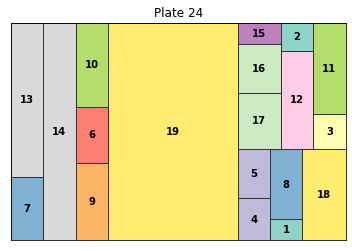

Instance[24] solved in 3.095 s, height: 31


Instance: n=27 w=32 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]
LB -> 32
UB -> 37


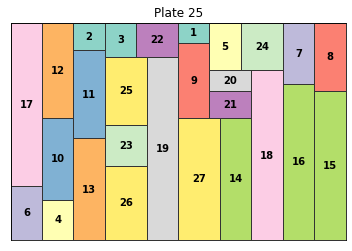

Instance[25] solved in 33.463 s, height: 32


Instance: n=23 w=33 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]
LB -> 33
UB -> 37


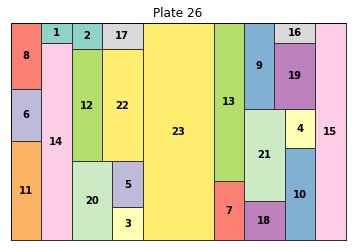

Instance[26] solved in 9.239 s, height: 33


Instance: n=21 w=34 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]
LB -> 34
UB -> 36


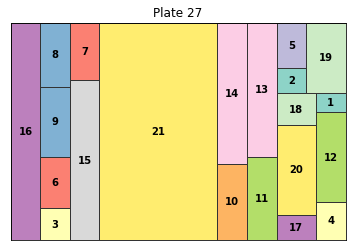

Instance[27] solved in 4.095 s, height: 34


Instance: n=22 w=35 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]
LB -> 35
UB -> 38


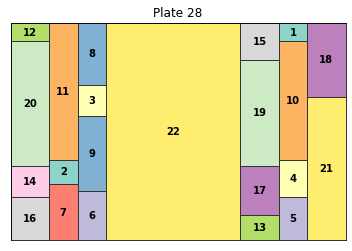

Instance[28] solved in 4.728 s, height: 35


Instance: n=23 w=36 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]
LB -> 36
UB -> 38


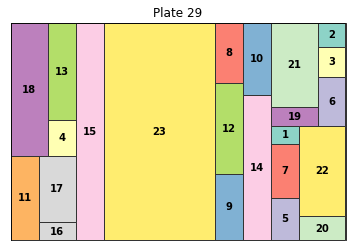

Instance[29] solved in 6.399 s, height: 36


Instance: n=27 w=37 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]
LB -> 37
UB -> 42


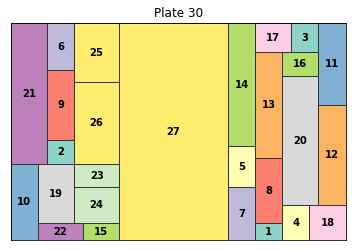

Instance[30] solved in 99.342 s, height: 37


Instance: n=19 w=38 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]
LB -> 38
UB -> 43


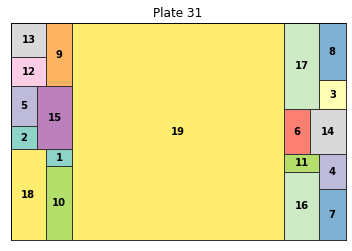

Instance[31] solved in 5.386 s, height: 38


Instance: n=29 w=39 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]
LB -> 39
UB -> 44


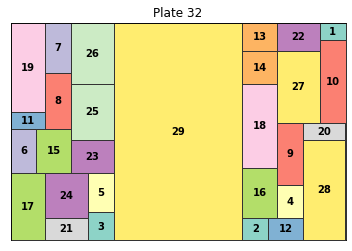

Instance[32] solved in 48.987 s, height: 39


Instance: n=20 w=40 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]
LB -> 40
UB -> 44


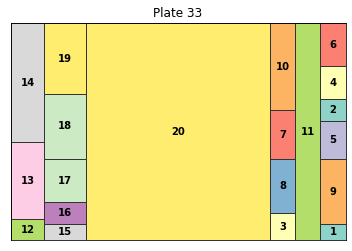

Instance[33] solved in 4.836 s, height: 40


Instance: n=25 w=15 dim=[[3, 11], [3, 13], [2, 9], [2, 7], [3, 9], [3, 7], [2, 11], [2, 13], [4, 11], [4, 13], [5, 3], [2, 11], [2, 2], [3, 11], [3, 2], [4, 5], [4, 6], [2, 12], [2, 1], [5, 3], [5, 13], [4, 12], [4, 1], [2, 5], [2, 6]]
LB -> 40
UB -> 44


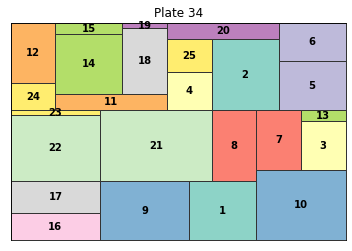

Instance[34] solved in 22.154 s, height: 40


Instance: n=25 w=15 dim=[[2, 11], [3, 2], [7, 10], [4, 8], [5, 9], [2, 7], [1, 4], [1, 6], [5, 4], [3, 8], [3, 1], [5, 5], [1, 3], [4, 12], [2, 6], [4, 2], [4, 11], [2, 10], [2, 3], [2, 11], [4, 3], [4, 26], [4, 8], [2, 3], [2, 6]]
LB -> 40
UB -> 42


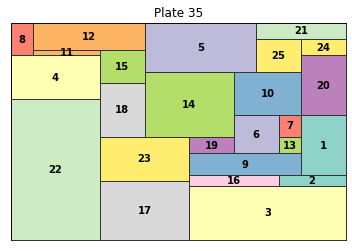

Instance[35] solved in 6.52 s, height: 40


Instance: n=25 w=15 dim=[[7, 12], [7, 7], [1, 7], [1, 5], [2, 3], [2, 6], [2, 7], [2, 5], [1, 3], [1, 6], [6, 12], [6, 9], [2, 12], [2, 7], [3, 10], [1, 4], [1, 5], [3, 16], [3, 5], [2, 4], [2, 5], [3, 10], [3, 9], [3, 16], [3, 5]]
LB -> 40
UB -> 44


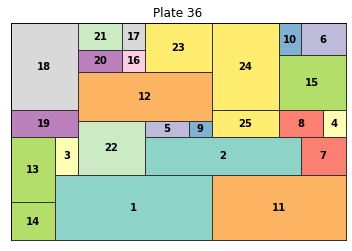

Instance[36] solved in 5.785 s, height: 40


Instance: n=28 w=30 dim=[[5, 7], [5, 14], [8, 14], [8, 4], [13, 21], [11, 7], [11, 14], [5, 14], [5, 4], [3, 18], [3, 21], [11, 17], [11, 4], [4, 7], [4, 5], [7, 6], [5, 18], [5, 3], [3, 7], [3, 5], [4, 18], [4, 3], [2, 12], [2, 6], [5, 18], [5, 21], [3, 17], [3, 4]]
LB -> 60
UB -> 66


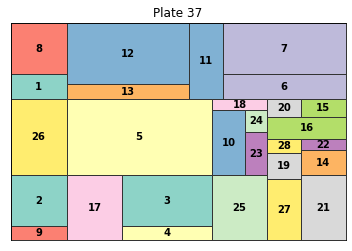

Instance[37] solved in 36.851 s, height: 60


Instance: n=29 w=30 dim=[[6, 18], [2, 12], [10, 7], [4, 23], [4, 1], [7, 7], [11, 4], [6, 5], [2, 7], [6, 11], [10, 19], [11, 5], [4, 2], [7, 5], [4, 2], [7, 12], [7, 13], [3, 6], [6, 10], [9, 16], [1, 4], [4, 10], [6, 24], [9, 9], [2, 1], [8, 5], [3, 5], [7, 25], [5, 21]]
LB -> 60
UB -> 65


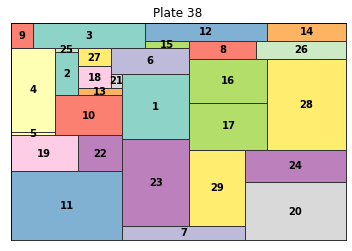

Instance[38] solved in 102.21 s, height: 60


Instance: n=28 w=30 dim=[[9, 24], [9, 8], [9, 11], [9, 17], [4, 24], [4, 8], [1, 6], [1, 5], [4, 17], [3, 6], [3, 5], [12, 5], [12, 13], [14, 14], [2, 14], [2, 2], [8, 3], [8, 9], [12, 14], [12, 2], [6, 3], [6, 9], [2, 5], [2, 13], [3, 18], [3, 14], [3, 16], [3, 12]]
LB -> 60
UB -> 67


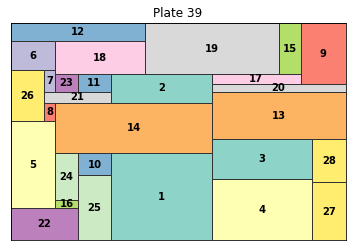

Instance[39] solved in 95.305 s, height: 60


Instance: n=73 w=60 dim=[[34, 6], [13, 3], [13, 5], [10, 12], [10, 12], [6, 7], [6, 15], [25, 7], [25, 15], [21, 12], [16, 7], [16, 5], [21, 3], [21, 5], [5, 7], [5, 5], [4, 1], [4, 10], [6, 13], [12, 13], [12, 9], [23, 6], [7, 3], [7, 5], [2, 1], [2, 10], [6, 6], [6, 5], [14, 7], [14, 6], [16, 3], [16, 5], [14, 6], [14, 5], [14, 13], [3, 2], [3, 7], [11, 2], [11, 7], [6, 7], [6, 6], [33, 14], [12, 4], [12, 3], [16, 18], [12, 3], [12, 18], [4, 4], [4, 3], [3, 1], [3, 2], [6, 9], [6, 9], [6, 1], [6, 2], [5, 7], [5, 18], [3, 9], [3, 9], [9, 18], [6, 5], [6, 2], [2, 12], [2, 9], [8, 3], [8, 9], [10, 9], [3, 5], [3, 2], [3, 18], [3, 7], [2, 3], [2, 9]]
LB -> 90
UB -> 96
Out of time




In [61]:
from_ins = 1
to_ins   = 40

times_no_r = []
for ins in range(from_ins, min(to_ins+1,41)):
    print('========================================================================================')

    # Instance
    instance=utils.loadInstance(f"../instances/ins-{ins}.txt")
    print("Instance:",*["{}={}".format(key,val) for key,val in instance.items()])

    # Solving
    s,px,py,H,e_time = vlsi_sat(instance)
    
    times_no_r.append(round(e_time,3))
    if e_time == 0.0:
        print("Out of time")
    else:
        m = s.model() 
        n = instance['n']
        W = instance['w']
        widths  = [i[0] for i in instance['dim']]
        heights = [i[1] for i in instance['dim']]

        # Get coordinates
        cx, cy = getCoords(m,px,py,W,H,n)
        sol=[[W,H]]+[[widths[i],heights[i],cx[i]+1,cy[i]+1] for i in range(n)]
        
        # Write to file
        utils.writeSolution('./outputs/out-' + str(ins) + '.txt', sol)

        # Read from file
        sol = utils.readSolution(f"./outputs/out-{ins}.txt")
        
        utils.display_solution(sol, title= f'Plate {ins}')

        # Time
        print(f'Instance[{ins}] solved in {round(e_time,3)} s, height: {H}')
    print('========================================================================================')
    print('\n')

### Model with rotations

In [60]:
def vlsi_sat_rotations(instance):
    
    ''' VARIABLES '''

    n = instance['n']
    W = instance['w']
        
    widths  = [i[0] for i in instance['dim']]
    heights = [i[1] for i in instance['dim']]

    largest_idx = [w*h for w,h in zip(widths,heights)].index(max([w*h for w,h in\
                                                                        zip(widths,heights)]))   
    
    tot_area=sum([w*h for w,h in zip(widths,heights)])

    lb = int(tot_area/W)
    naiveSolution = utils.computeMostStupidSolution(instance)
    ub = naiveSolution[0][1]+1
    
    print("LB ->", lb)
    print("UB ->", ub)
    
    H = lb
    
    s_time = time.time()
    
    ''' SOLVER WITH 5 MINUTES TIMEOUT'''
    s = Solver()
    s.set("timeout", 300000)
    while (lb < ub):
        if (time.time() > s_time + 300):
            return s, None, None, None, 0.0, None
        
        '''
        ==================================================================
        The variable "f" points wether a component is flipped or not.
        ==================================================================
        '''
        px = [[Bool(f"px{i+1}_{x}") for x in range(W)] for i in range(n)] # x[i][i]: block i has y coordinate <=j
        py = [[Bool(f"py{i+1}_{y}") for y in range(H)] for i in range(n)] # x[i][i]: block i has y coordinate <=j
        lr = [[Bool(f"lr_{i+1}_{j+1}") if j!=i else 0 for j in range(n)] for i in range(n)]
        ud = [[Bool(f"ud_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)]
        f = [Bool(f"f{i+1}") for i in range(n)] # f[i]: block i is flipped

        # Exactly One constraint
        for i in range(n): 
            '''
            ==================================================================
            Ranges of each component change depending on "f".
            ==================================================================
            '''
            
            if largest_rectangle(i, largest_idx):
                if heights[i] <= W:
                    s.add(Or(
                            And (Not(f[i]), And([px[i][e] for e in range(int((W-widths[i])/2),W)])),
                            And ( f[i],      And([px[i][e] for e in range(int((W-heights[i])/2),W)]))
                    )) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 
                else:
                     s.add(
                            And (Not(f[i]), And([px[i][e] for e in range(int((W-widths[i])/2),W)]))
                    ) 
                
                if widths[i] <= H:
                    s.add(Or(
                        And (Not(f[i]), And([py[i][f] for f in range(int((H-heights[i])/2),H)])),
                        And (f[i],      And([py[i][f] for f in range(int((H-widths[i])/2),H)]))
                    )) # same for the y coordinate 
                else:
                    s.add(
                        And (Not(f[i]), And([py[i][f] for f in range(int((H-heights[i])/2),H)]))
                    ) # same for the y coordinate 
            else:
                if heights[i] <= W:
                    s.add(Or(
                            And (Not(f[i]), And([px[i][e] for e in range(W-widths[i],W)])),
                            And ( f[i],      And([px[i][e] for e in range(W-heights[i],W)]))
                        )) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 
                else:
                    s.add(
                            And (Not(f[i]), And([px[i][e] for e in range(W-widths[i],W)]))
                        ) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 

                if widths[i] <= H:
                    s.add(Or(
                        And (Not(f[i]), And([py[i][f] for f in range(H-heights[i],H)])),
                        And (f[i],      And([py[i][f] for f in range(H-widths[i],H)]))
                        )) # same for the y coordinate    
                else:
                    s.add(
                        And (Not(f[i]), And([py[i][f] for f in range(H-heights[i],H)]))
                        ) # same for the y coordinate    

            s.add([Or(Not(px[i][e]),px[i][e+1]) for e in range(W-1)]) #x[i][j] implies x[i][j+1]
            s.add([Or(Not(py[i][f]),py[i][f+1]) for f in range(H-1)]) #y[i][j] implies y[i][j+1]

            for j in range(n):
                '''
                ==================================================================
                We must take in account the four possible orientations of
                two components.
                ==================================================================
                '''
                if large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "":
                    if i<j and not same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                        if not largest_rectangle(j, largest_idx):
                            s.add(Or(lr[i][j],lr[j][i],ud[i][j],ud[j][i]))

                            s.add(Or(
                                    And(
                                        Not(f[i]), Not(f[j]),
                                        *no_overlap(W,H,widths,heights,i,j,False,\
                                                    px,py,lr,ud),
                                        *no_overlap(W,H,widths,heights,j,i,False,\
                                                    px,py,lr,ud)
                                    ),
                                    And(
                                        Not(f[i]), f[j],
                                        *no_overlap(W,H,widths,heights,i,j,False,\
                                                    px,py,lr,ud),
                                        *no_overlap(W,H,widths,heights,j,i,True,\
                                                    px,py,lr,ud)
                                    ),
                                    And(
                                        f[i], Not(f[j]),
                                        *no_overlap(W,H,widths,heights,i,j,True,\
                                                    px,py,lr,ud),
                                        *no_overlap(W,H,widths,heights,j,i,False,\
                                                    px,py,lr,ud)
                                    ),
                                    And(
                                        f[i], f[j],
                                        *no_overlap(W,H,widths,heights,i,j,True,\
                                                    px,py,lr,ud),
                                        *no_overlap(W,H,widths,heights,j,i,True,\
                                                    px,py,lr,ud)
                                    )
                            ))
                            
                        else:
                            s.add(Or(lr[j][i],ud[i][j],ud[j][i]))
                            
                            s.add(Or(
                                    And(
                                        Not(f[i]), Not(f[j]),
                                        *no_overlap(W,H,widths,heights,i,j,False,\
                                                    px,py,False,ud),
                                        *no_overlap(W,H,widths,heights,j,i,False,\
                                                    px,py,lr,ud)
                                    ),
                                    And(
                                        Not(f[i]), f[j],
                                        *no_overlap(W,H,widths,heights,i,j,False,\
                                                    px,py,False,ud),
                                        *no_overlap(W,H,widths,heights,j,i,True,\
                                                    px,py,lr,ud)
                                    ),
                                    And(
                                        f[i], Not(f[j]),
                                        *no_overlap(W,H,widths,heights,i,j,True,\
                                                    px,py,False,ud),
                                        *no_overlap(W,H,widths,heights,j,i,False,\
                                                    px,py,lr,ud)
                                    ),
                                    And(
                                        f[i], f[j],
                                        *no_overlap(W,H,widths,heights,i,j,True,\
                                                    px,py,False,ud),
                                        *no_overlap(W,H,widths,heights,j,i,True,\
                                                    px,py,lr,ud)
                                    )
                            ))
                            
                    elif i<j and same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                        s.add(Or(lr[i][j],ud[i][j],ud[j][i]))
                        
                        s.add(Or(
                                And(
                                    Not(f[i]), Not(f[j]),
                                    *no_overlap(W,H,widths,heights,i,j,False,\
                                                px,py,lr,ud),
                                    *no_overlap(W,H,widths,heights,j,i,False,\
                                                px,py,False,ud)
                                ),
                                And(
                                    Not(f[i]), f[j],
                                    *no_overlap(W,H,widths,heights,i,j,False,\
                                                px,py,lr,ud),
                                    *no_overlap(W,H,widths,heights,j,i,True,\
                                                px,py,False,ud)
                                ),
                                And(
                                    f[i], Not(f[j]),
                                    *no_overlap(W,H,widths,heights,i,j,True,\
                                                px,py,lr,ud),
                                    *no_overlap(W,H,widths,heights,j,i,False,\
                                                px,py,False,ud)
                                ),
                                And(
                                    f[i], f[j],
                                    *no_overlap(W,H,widths,heights,i,j,True,\
                                                px,py,lr,ud),
                                    *no_overlap(W,H,widths,heights,j,i,True,\
                                                px,py,False,ud)
                                )
                        ))
                            
                        s.add(Or(
                                Not(ud[i][j]),
                                lr[j][i]
                        ))
                        
                elif large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "W":
                    if i<j:
                        s.add(Or(ud[i][j],ud[j][i]))

                        s.add(Or(
                                And(
                                    Not(f[i]), Not(f[j]),
                                    *no_overlap(W,H,widths,heights,i,j,False,\
                                                px,py,False,ud),
                                    *no_overlap(W,H,widths,heights,j,i,False,\
                                                px,py,False,ud)
                                ),
                                And(
                                    Not(f[i]), f[j],
                                    *no_overlap(W,H,widths,heights,i,j,False,\
                                                px,py,False,ud),
                                    *no_overlap(W,H,widths,heights,j,i,True,\
                                                px,py,False,ud)
                                ),
                                And(
                                    f[i], Not(f[j]),
                                    *no_overlap(W,H,widths,heights,i,j,True,\
                                                px,py,False,ud),
                                    *no_overlap(W,H,widths,heights,j,i,False,\
                                                px,py,False,ud)
                                ),
                                And(
                                    f[i], f[j],
                                    *no_overlap(W,H,widths,heights,i,j,True,\
                                                px,py,False,ud),
                                    *no_overlap(W,H,widths,heights,j,i,True,\
                                                px,py,False,ud)
                                )
                        ))
                        
                elif large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "H":
                    if i<j and not same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                        s.add(Or(lr[i][j],lr[j][i]))

                        s.add(Or(
                                And(
                                    Not(f[i]), Not(f[j]),
                                    *no_overlap(W,H,widths,heights,i,j,False,\
                                                px,py,lr,False),
                                    *no_overlap(W,H,widths,heights,j,i,False,\
                                                px,py,lr,False)
                                ),
                                And(
                                    Not(f[i]), f[j],
                                    *no_overlap(W,H,widths,heights,i,j,False,\
                                                px,py,lr,False),
                                    *no_overlap(W,H,widths,heights,j,i,True,\
                                                px,py,lr,False)
                                ),
                                And(
                                    f[i], Not(f[j]),
                                    *no_overlap(W,H,widths,heights,i,j,True,\
                                                px,py,lr,False),
                                    *no_overlap(W,H,widths,heights,j,i,False,\
                                                px,py,lr,False)
                                ),
                                And(
                                    f[i], f[j],
                                    *no_overlap(W,H,widths,heights,i,j,True,\
                                                px,py,lr,False),
                                    *no_overlap(W,H,widths,heights,j,i,True,\
                                                px,py,lr,False)
                                )
                        ))
                        
                    elif i<j and same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                        s.add(lr[i][j])
                        
                        s.add(Or(
                                And(
                                    Not(f[i]), Not(f[j]),
                                    *no_overlap(W,H,widths,heights,i,j,False,\
                                                px,py,lr,False)
                                ),
                                And(
                                    Not(f[i]), f[j],
                                    *no_overlap(W,H,widths,heights,i,j,False,\
                                                px,py,lr,False)
                                ),
                                And(
                                    f[i], Not(f[j]),
                                    *no_overlap(W,H,widths,heights,i,j,True,\
                                                px,py,lr,False)
                                ),
                                And(
                                    f[i], f[j],
                                    *no_overlap(W,H,widths,heights,i,j,True,\
                                                px,py,lr,False)
                                )
                        ))
                        
                        s.add(
                            *no_overlap(W,H,widths,heights,i,j,False,False,px,py,lr,False)
                        )
                        
                        s.add(Or(
                                Not(ud[i][j]),
                                lr[j][i]
                        ))                    

        if s.check() == sat:
            ub = H
        else:
            lb = H + 1

        H =  int((lb+ub)/2)
        
        '''
        ==================================================================
        'Bisection Method':
            while lb < ub
                o := (lb + ub)/2;
                resubt := Ψ ∪ {ph_o};
                if resubt is SAT
                    then ub := o;
                    else lb := o + 1;
            end while
        ==================================================================
        '''
    
    e_time = time.time() - s_time
    
    return s, px, py, H, e_time,f

Instance: n=25 w=15 dim=[[7, 12], [7, 7], [1, 7], [1, 5], [2, 3], [2, 6], [2, 7], [2, 5], [1, 3], [1, 6], [6, 12], [6, 9], [2, 12], [2, 7], [3, 10], [1, 4], [1, 5], [3, 16], [3, 5], [2, 4], [2, 5], [3, 10], [3, 9], [3, 16], [3, 5]]
LB -> 40
UB -> 44


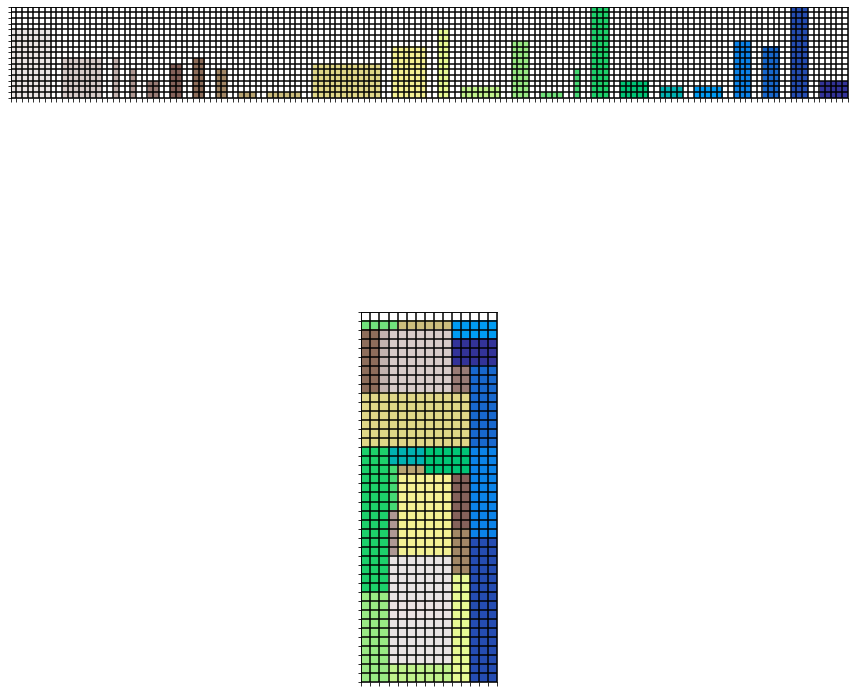

[[15, 40], [7, 12, 4, 3], [7, 7, 4, 33], [1, 7, 3, 33], [1, 5, 4, 15], [2, 3, 11, 33], [2, 6, 11, 18], [2, 7, 1, 33], [2, 5, 11, 13], [3, 1, 5, 24], [6, 1, 5, 40], [12, 6, 1, 27], [6, 9, 5, 15], [2, 12, 11, 1], [7, 2, 4, 1], [3, 10, 1, 1], [4, 1, 1, 40], [1, 5, 4, 20], [3, 16, 1, 11], [5, 3, 8, 24], [4, 2, 4, 25], [5, 2, 11, 39], [3, 10, 13, 17], [3, 9, 13, 27], [3, 16, 13, 1], [5, 3, 11, 36]]
Instance[36] solved in 30.334 s, height: 40




In [70]:
from_ins = 36
to_ins   = 36

times_r = []
for ins in range(from_ins, min(to_ins+1,41)):
    print('========================================================================================')

    # Instance
    instance=utils.loadInstance(f"../instances/ins-{ins}.txt")
    print("Instance:",*["{}={}".format(key,val) for key,val in instance.items()])

    # Solving
    s,px,py,H,e_time,f = vlsi_sat_rotations(instance)
    
    times_r.append(round(e_time,3))
    if e_time == 0.0:
        print("Out of time")
    else:
        m = s.model() 
        n = instance['n']
        W = instance['w']
        widths  = [i[0] for i in instance['dim']]
        heights = [i[1] for i in instance['dim']]

        # Get coordinates
        cx, cy = getCoords(m,px,py,W,H,n)
        new_widths,new_heights=getNewDims(m,widths,heights,f, W, H)
        
        sol=[[W,H]]+[[new_widths[i],new_heights[i],cx[i]+1,cy[i]+1] for i in range(n)]
        
        # Write to file
        utils.writeSolution('./outputs_rot/out-' + str(ins) + '.txt', sol)

        # Read from file
        sol = utils.readSolution(f"./outputs_rot/out-{ins}.txt")
        
        #utils.display_solution(sol, title= f'Plate {ins}')
        utils.show(sol, figsize=(15,15))
        
        print(sol)

        # Time
        print(f'Instance[{ins}] solved in {round(e_time,3)} s, height: {H}')
    print('========================================================================================')
    print('\n')

Instance: n=25 w=15 dim=[[7, 12], [7, 7], [1, 7], [1, 5], [2, 3], [2, 6], [2, 7], [2, 5], [1, 3], [1, 6], [6, 12], [6, 9], [2, 12], [2, 7], [3, 10], [1, 4], [1, 5], [3, 16], [3, 5], [2, 4], [2, 5], [3, 10], [3, 9], [3, 16], [3, 5]]
LB -> 40
UB -> 44


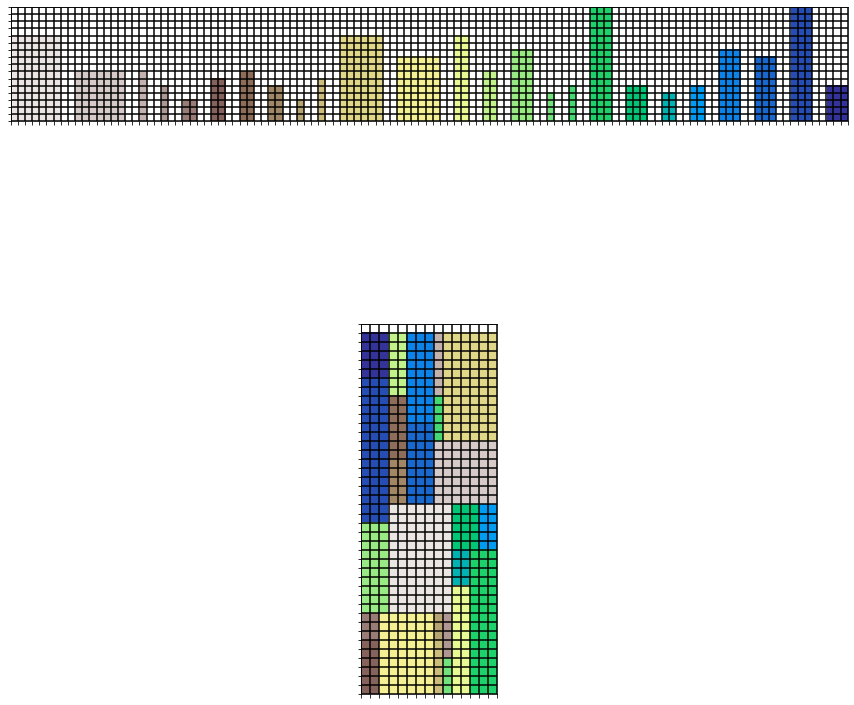

[[15, 40], [7, 12, 4, 10], [7, 7, 9, 22], [1, 7, 9, 34], [1, 5, 10, 5], [2, 3, 1, 7], [2, 6, 1, 1], [2, 7, 4, 27], [2, 5, 4, 22], [1, 3, 9, 7], [1, 6, 9, 1], [6, 12, 10, 29], [6, 9, 3, 1], [2, 12, 11, 1], [2, 7, 4, 34], [3, 10, 1, 10], [1, 4, 10, 1], [1, 5, 9, 29], [3, 16, 13, 1], [3, 5, 11, 17], [2, 4, 11, 13], [2, 5, 14, 17], [3, 10, 6, 31], [3, 9, 6, 22], [3, 16, 1, 20], [3, 5, 1, 36]]
Instance[36] solved in 6.765 s, height: 40




In [69]:
 
for ins in range(from_ins, min(to_ins+1,41)):
    print('========================================================================================')

    # Instance
    instance=utils.loadInstance(f"../instances/ins-{ins}.txt")
    print("Instance:",*["{}={}".format(key,val) for key,val in instance.items()])

    # Solving
    s,px,py,H,e_time = vlsi_sat(instance)
    
    times_r.append(round(e_time,3))
    if e_time == 0.0:
        print("Out of time")
    else:
        m = s.model() 
        n = instance['n']
        W = instance['w']
        widths  = [i[0] for i in instance['dim']]
        heights = [i[1] for i in instance['dim']]

        # Get coordinates
        cx, cy = getCoords(m,px,py,W,H,n)
        
        sol=[[W,H]]+[[widths[i],heights[i],cx[i]+1,cy[i]+1] for i in range(n)]
        
        # Write to file
        utils.writeSolution('./outputs_rot/out-' + str(ins) + '.txt', sol)

        # Read from file
        sol = utils.readSolution(f"./outputs_rot/out-{ins}.txt")
        
        #utils.display_solution(sol, title= f'Plate {ins}')
        utils.show(sol, figsize=(15,15))
        
        print(sol)

        # Time
        print(f'Instance[{ins}] solved in {round(e_time,3)} s, height: {H}')
    print('========================================================================================')
    print('\n')

In [16]:
times_no_r = [0.037,0.055,0.084,0.131,0.219,0.257,0.275,0.347,0.372,0.675,\
              3.125,1.010,1.002,1.282,1.410,2.471,2.048,5.460,17.723,3.154,\
              15.707,13.546,8.033,3.095,33.463,9.239,4.095,4.728,6.399,99.342,\
             5.386, 48.987,4.836,22.154,6.52,5.785,36.851,102.21,95.305,0.0]